In [2]:
from datetime import datetime
import itertools
import json

import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import torch
from torch.utils.data import DataLoader

from database import data_utils, data_loader, shape_utils
from models import basic_ff
import run_models

importlib.reload(data_utils)
importlib.reload(basic_ff)
importlib.reload(data_loader)
importlib.reload(shape_utils)

RUN_FOLDER = "../results/throwaway/"

In [3]:
train_traces = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "train_traces.pkl")
test_traces = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "test_traces.pkl")
with open(RUN_FOLDER + "kcm/deeptte_formatted/" + "config.json") as f:
    config = json.load(f)
gtfs_data = data_utils.merge_gtfs_files("." + config['gtfs_folder'])

In [20]:
t_model = data_utils.load_pkl(RUN_FOLDER + "kcm/models/sch_model_4" + ".pkl")
tte_train_chunks, tte_test = data_utils.load_train_test_data(RUN_FOLDER + "kcm/deeptte_formatted/", 5)

In [24]:
labels = [x['time'] for x in tte_test]
preds = t_model.predict_simple_sch(tte_test, gtfs_data)

In [41]:
stop_dists = [x['stop_dist_km'] for x in tte_test]

In [45]:
tte_test[0]['trip_start_timeID_s']

26376

In [44]:
tte_test[0].keys()

dict_keys(['time_gap', 'dist_gap', 'dist', 'lats', 'lngs', 'driverID', 'weekID', 'timeID', 'dateID', 'trip_id', 'file', 'speed_m_s', 'time_calc_s', 'dist_calc_km', 'trip_start_timeID_s', 'timeID_s', 'stop_lat', 'stop_lon', 'stop_dist_km', 'scheduled_time_s', 'time'])

In [30]:
metrics.mean_absolute_percentage_error(labels, preds)

0.4980671107187768

<AxesSubplot: ylabel='Count'>

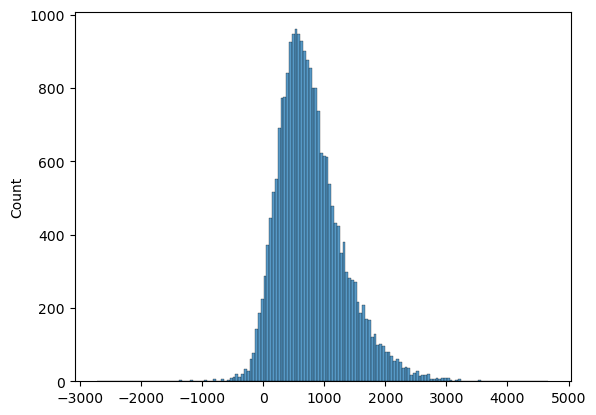

In [29]:
sns.histplot(preds)

<AxesSubplot: ylabel='Count'>

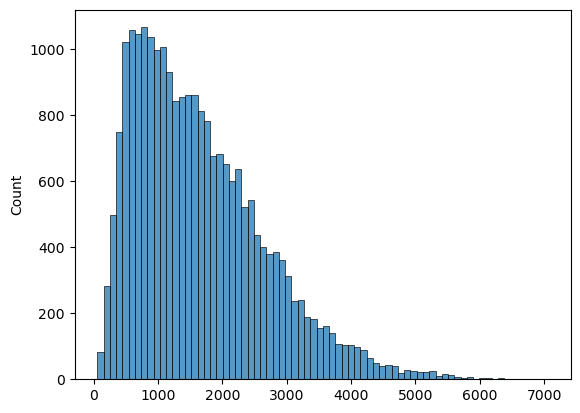

In [28]:
sns.histplot(labels)

In [4]:
train_traces.head()

,trip_id,file,locationtime,lat,lon,vehicle_id,speed_m_s,dist_calc_m,time_calc_s,bearing,...,timeID,timeID_s,shingle_id,stop_dist_km,stop_arrival_s,stop_lon,stop_lat,trip_start_timeID_s,scheduled_time_s,vehicle_id_recode
0,34761963,2020_10_24.pkl,1603547169,47.615574,-122.195343,6025.0,6.634283,99.514248,15.0,180.3,...,406,24369,0,0.007803,24300,-122.195358,47.615505,24369,-69,1094
1,34761963,2020_10_24.pkl,1603547214,47.615963,-122.190948,6025.0,7.382834,332.227550,45.0,357.3,...,406,24414,0,0.492087,24300,-122.195358,47.615505,24369,-69,1094
2,34761963,2020_10_24.pkl,1603547274,47.617352,-122.189812,6025.0,2.939179,176.350742,60.0,326.9,...,407,24474,0,0.540485,24417,-122.184944,47.61723,24369,48,1094
3,34761963,2020_10_24.pkl,1603547323,47.617298,-122.184029,6025.0,8.847076,433.506734,49.0,0.3,...,408,24523,0,0.101892,24417,-122.184944,47.61723,24369,48,1094
4,34761963,2020_10_24.pkl,1603547352,47.617325,-122.179306,6025.0,12.206578,353.990749,29.0,359.8,...,409,24552,0,0.071511,24462,-122.179947,47.61726,24369,93,1094


In [5]:
gtfs_data.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,peak_flag,fare_id,...,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,arrival_s
0,100160,128901,34745815,Overlake,LOCAL,0,5891543,11269002,0,101,...,Issaquah Transit Center - Bay 5,NaN,47.542252,-122.062225,19,NaN,0,NaN,America/Los_Angeles,26340
49,100160,128901,34745815,Overlake,LOCAL,0,5891543,11269002,0,101,...,NW Sammamish Rd & 11th Ave NW,NaN,47.551914,-122.053436,19,NaN,0,NaN,America/Los_Angeles,26511
73,100160,128901,34745815,Overlake,LOCAL,0,5891543,11269002,0,101,...,SE 56th St & 221st Pl SE,NaN,47.551895,-122.046417,19,NaN,0,NaN,America/Los_Angeles,26562
97,100160,128901,34745815,Overlake,LOCAL,0,5891543,11269002,0,101,...,SE 56th St & East Lake Sammamish Pkwy SE,NaN,47.551865,-122.044014,19,NaN,0,NaN,America/Los_Angeles,26580
121,100160,128901,34745815,Overlake,LOCAL,0,5891543,11269002,0,101,...,SE Black Nugget Rd & East Lake Sammamish Pkwy SE,NaN,47.549954,-122.040268,19,NaN,0,NaN,America/Los_Angeles,26647


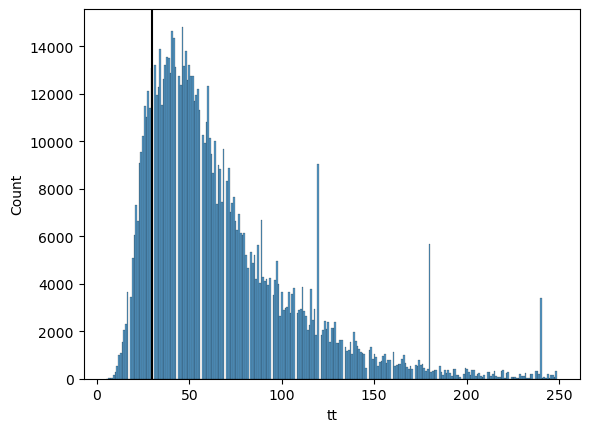

In [6]:
# Histogram of bus travel times in schedule
gtfs_data['arrival_s_prev'] = gtfs_data.groupby('trip_id').shift()[['arrival_s']]
gtfs_data_times = gtfs_data[['arrival_s','arrival_s_prev']].dropna()
gtfs_data_times['tt'] = gtfs_data_times['arrival_s'] - gtfs_data_times['arrival_s_prev']
# Time between bus stops
sns.histplot(gtfs_data_times.loc[gtfs_data_times['tt']<250, 'tt'])
plt.axvline(30, 0.0, 20000, color="black")

<AxesSubplot: xlabel='dist_calc_m', ylabel='Count'>

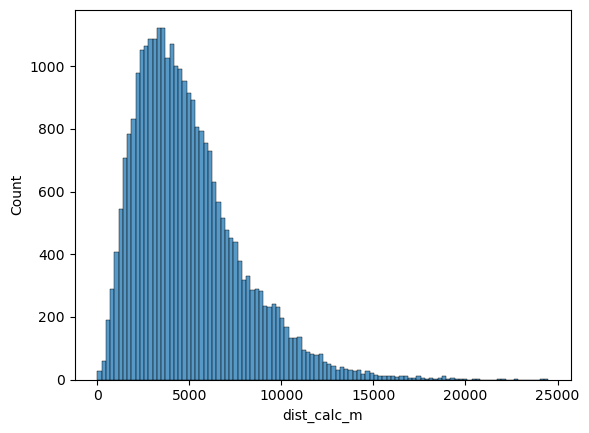

In [7]:
# Shingle distance
sns.histplot(train_traces.groupby('shingle_id').sum(numeric_only=True)['dist_calc_m'])

<AxesSubplot: xlabel='time_cumulative_s', ylabel='Count'>

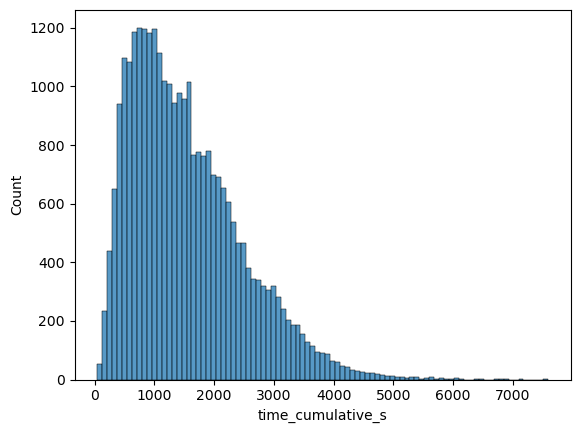

In [8]:
# Shingle travel time
sns.histplot(train_traces.groupby('shingle_id').last()['time_cumulative_s'])

<AxesSubplot: xlabel='lat', ylabel='Count'>

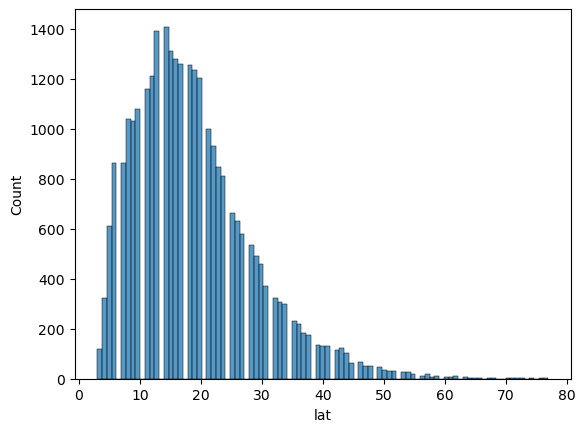

In [9]:
# Points per trajectory
sns.histplot(train_traces.groupby(['shingle_id']).count()['lat'])

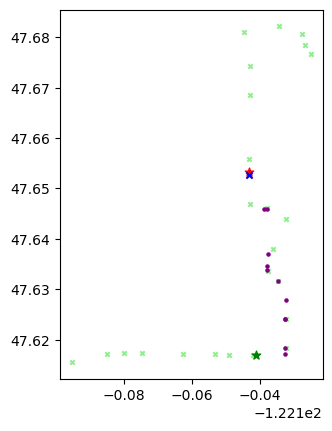

In [10]:
# Look at a single trip
shingle_num = 8
plot_data = train_traces[train_traces['shingle_id']==shingle_num]
fig, axes = plt.subplots(1,1)
shape_utils.plot_gtfs_trip(axes, plot_data['trip_id'].iloc[0], gtfs_data)
shape_utils.plot_gtfsrt_trip(axes, plot_data)